In [49]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import os


In [50]:
# Torchvision 변환 클래스
class TorchvisionTransform:
    def __init__(self, is_train: bool = True):
        common_transforms = [
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]
        
        if is_train:
            self.transform = A.Compose(
                [
                    A.RandomBrightnessContrast(brightness_limit=(-0.2, -0.2), contrast_limit=0, p=1), # 20% 어둡게
                    # transforms.RandomHorizontalFlip(p=0.5),
                    # transforms.RandomRotation(15),
                    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
                ] + common_transforms
            )
        else:
            self.transform = A.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        transformed = self.transform(image=image)
        return transformed['image']


In [51]:
# Albumentations 변환 클래스
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        common_transforms = [
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]
        
        if is_train:
            self.transform = A.Compose(
                [   
                    # A.OneOf([
                    #     A.RandomCrop(128, 128),  # 50% 확률로 랜덤 크롭 적용
                    #     A.Resize(224,224)
                    # ], p=1),
                    A.RandomResizedCrop(224, 224, scale=(0.5, 1.0))
                    # A.RandomResizedCrop(height=150, width=150, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1), 
                    # A.GridDistortion(always_apply=False, p=1, num_steps=1, distort_limit=(-0.03, 0.05), interpolation=2, border_mode=0, value=(255, 255, 255), mask_value=None),
                    # A.HorizontalFlip(p=0.9),  # 50% 확률로 이미지를 수평 뒤집기
                    # A.Rotate(limit=30),  # 최대 30도 회전
                    # A.RandomBrightnessContrast(brightness_limit=(-0.2, -0.2), contrast_limit=0, p=1), # 20% 어둡게
                    # A.Sharpen(alpha=(0.2, 0.5), lightness=(0.7, 1.3), p=1),
                    # A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=255, p=1)  # 흰색으로 드롭아웃
                    # A.BilateralBlur(d=5, sigma_color=75, sigma_space=75, p=0.5)
                    # A.GaussianBlur(blur_limit=(3, 5), p=1), # 약간의 블러 추가
                    # A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=1),
                    # A.GridDistortion(always_apply=False, p=1, num_steps=1, distort_limit=(-0.03, 0.05, interpolation=2, border_mode=0, value=(255, 255, 255), mask_value=None)
                    # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=1),
                    # A.GridDistortion(always_apply=False, p=1, num_steps=1, distort_limit=(-0.029999999329447746, 0.05000000074505806), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None)
                    # A.RandomResizedCrop(height=112, width=112, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1),
                    # A.GaussianBlur(blur_limit=(3, 5), p=1), # 약간의 블러 추가
                    # A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
                    # A.HorizontalFlip(p=0.5),
                    # A.Rotate(limit=15),
                    # A.RandomBrightnessContrast(p=0.1),
                    # A.RandomBrightnessContrast(brightness_limit=(-0.2, -0.2), contrast_limit=0, p=1.0), #밝기 20% 어둡게
                    # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
                    # A.GaussianBlur(blur_limit=(3, 5), p=0.6),  # 가우시안 블러
                    # A.ElasticTransform(alpha=10, sigma=50, alpha_affine=50, p=1),
                    # A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3), 
                    #A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3), 
                ] + common_transforms
            )
        else:
            self.transform = A.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        transformed = self.transform(image=image)
        return transformed['image']

In [52]:
# 시각적으로 변환된 이미지를 비교하는 함수
def plot_image_comparison(original_img, torchvision_img, albumentations_img, idx):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(original_img)
    ax[0].set_title(f'Original Image {idx}')
    
    ax[1].imshow(torchvision_img.permute(1, 2, 0))  # torch tensor는 (C, H, W)이므로 (H, W, C)로 변환
    ax[1].set_title('Albumentations Original')
    
    ax[2].imshow(albumentations_img.permute(1, 2, 0))
    ax[2].set_title('Albumentations Transform')
    
    for a in ax:
        a.axis('off')
    
    plt.show()

In [53]:
# 이미지 파일을 ./test_image 폴더에서 로드하는 함수
def load_images_from_folder(folder, num_images=10):
    images = []
    filenames = os.listdir(folder)
    for i, filename in enumerate(filenames):
        if i >= num_images:
            break
        img_path = os.path.join(folder, filename)
        img = np.array(Image.open(img_path).convert("RGB"))  # 이미지 파일을 NumPy 배열로 변환
        images.append((img, filename))
    return images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_44.JPEG


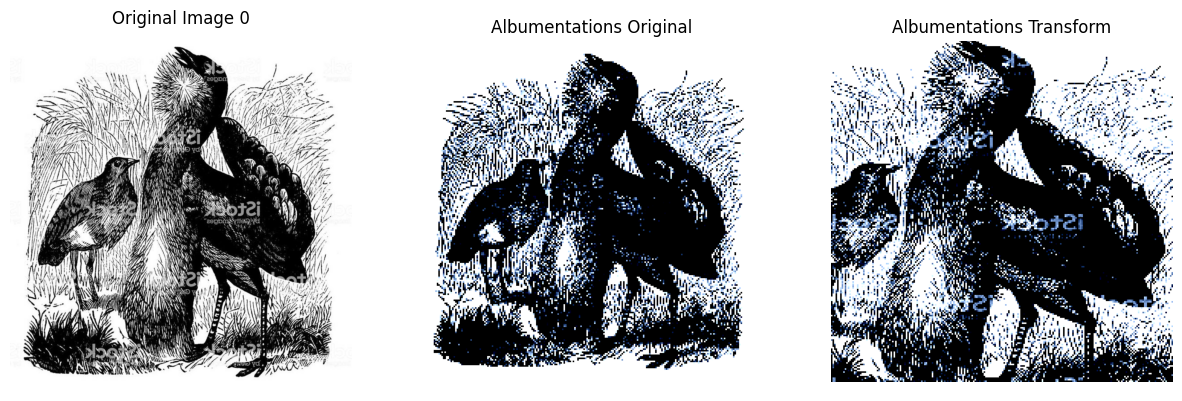

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_13.JPEG


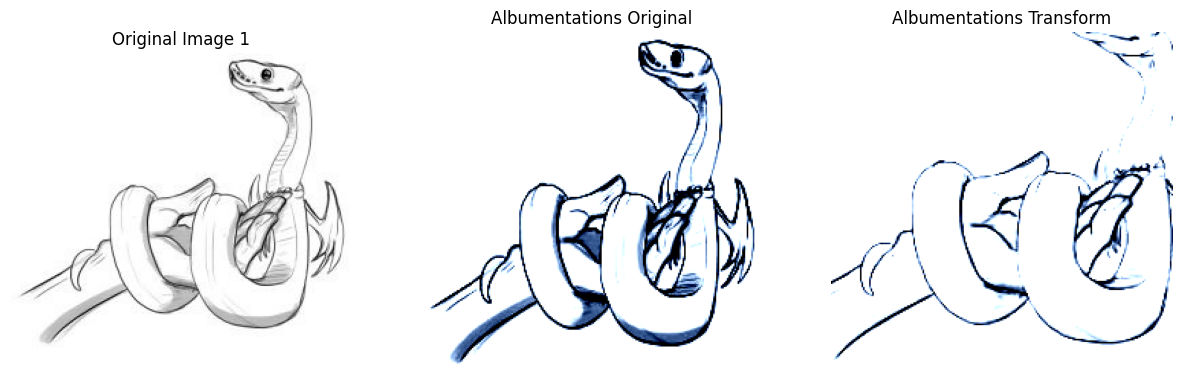

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_19.JPEG


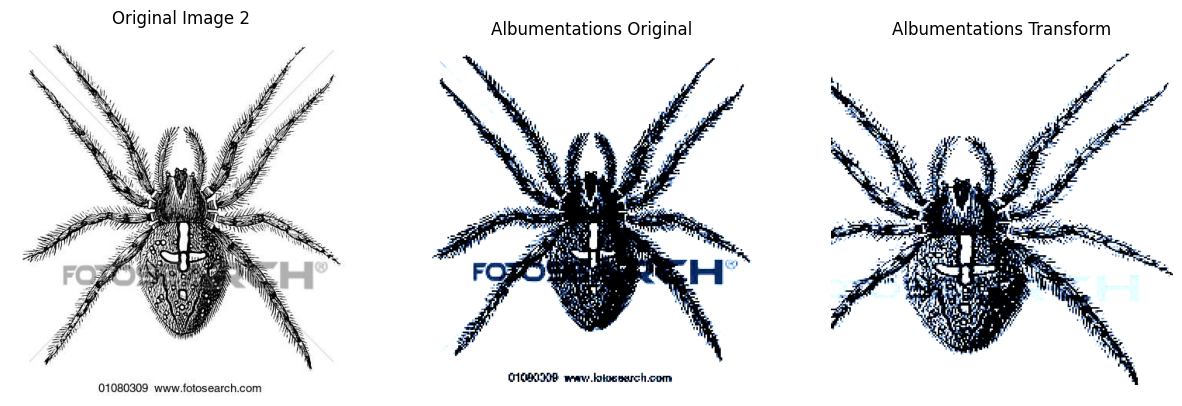

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_3.JPEG


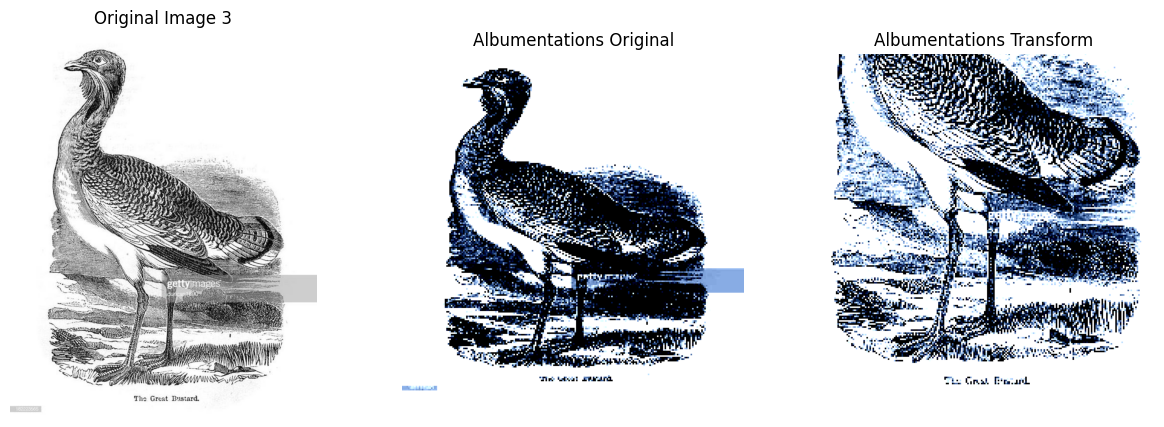

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_15.JPEG


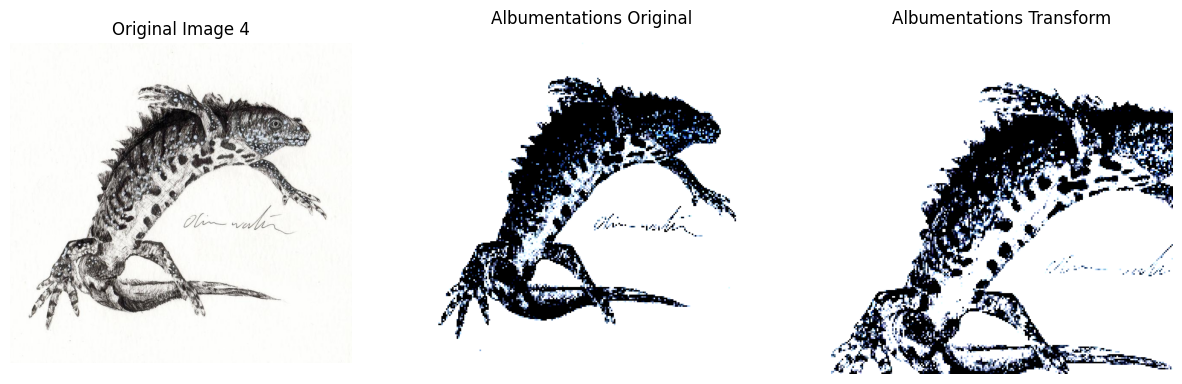

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_7.JPEG


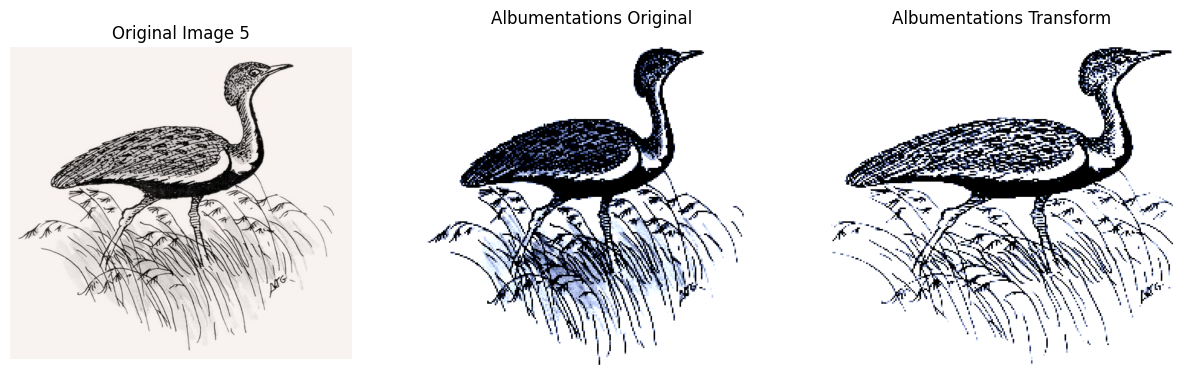

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_1.JPEG


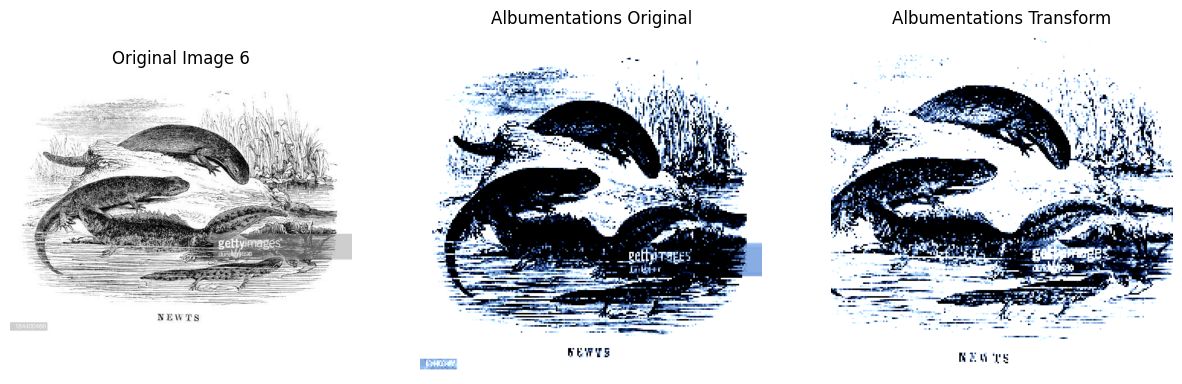

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_2.JPEG


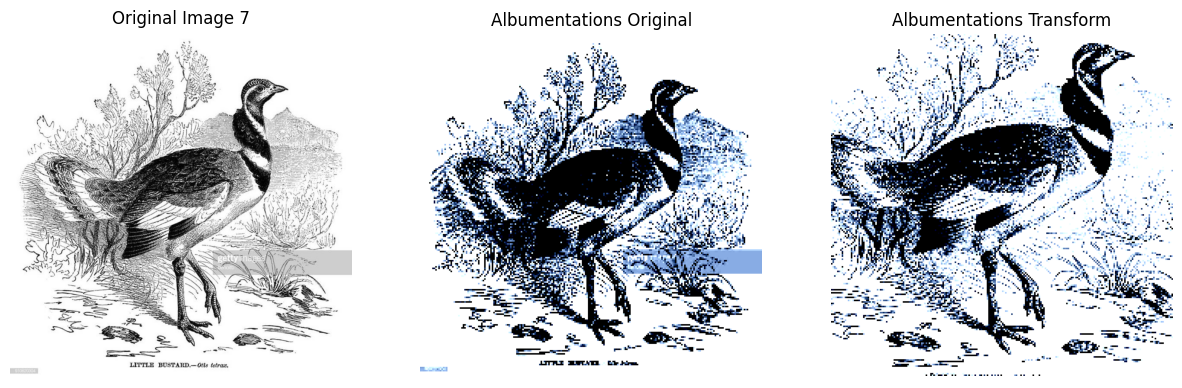

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_10.JPEG


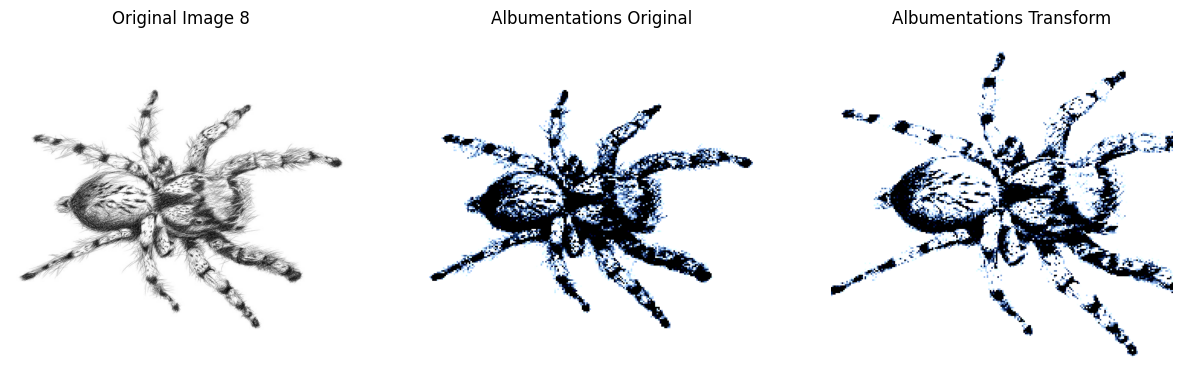

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing Image: sketch_8.JPEG


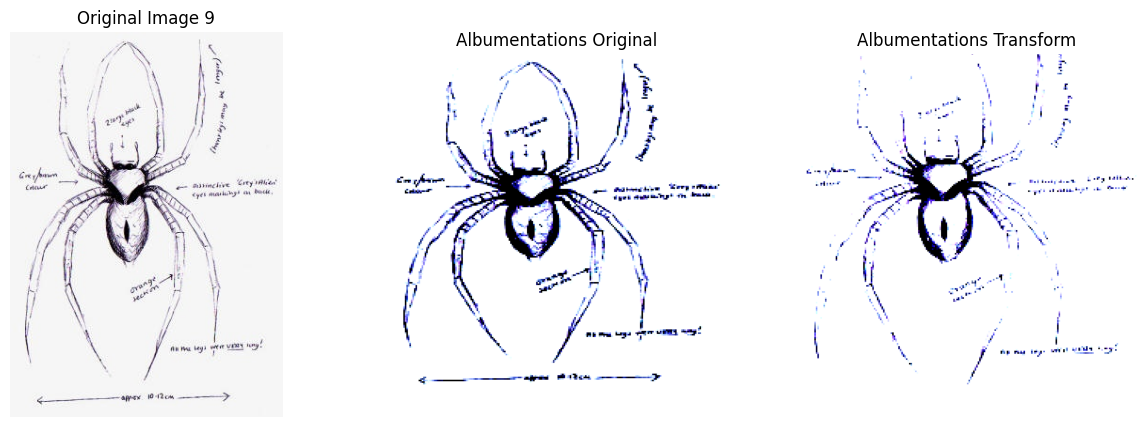

In [55]:
# ./test_image 폴더에서 이미지 로드
image_folder = './test_image'
num_images = 10
images = load_images_from_folder(image_folder, num_images)

# Torchvision 및 Albumentations 변환 생성
torchvision_transform = TorchvisionTransform(is_train=True)
albumentations_transform = AlbumentationsTransform(is_train=True)

# 10개의 이미지에 대해 변환 및 비교
for idx, (img, filename) in enumerate(images):
    # 원본 이미지
    original_img = img
    
    # Torchvision과 Albumentations 변환 적용
    torchvision_img = torchvision_transform(img)
    albumentations_img = albumentations_transform(img)
    
    # 시각적으로 비교
    print(f"Comparing Image: {filename}")
    plot_image_comparison(original_img, torchvision_img, albumentations_img, idx)
